In [8]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
plt.style.use("default")
font = {'size'   : 16}
plt.rc('font', **font)

In [9]:
def parseTiming(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Braid" in line: continue
            if "wall time" in line: return float(line.split()[-1])

def parseTol(fname, tol):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Begin" in line: continue
            if "not available" in line: continue
            if "Solver Stats" in line: continue
            if "Braid" in line and "wall time" in line:
                res = float(line.split()[5].split(',')[0])
                if res <= tol:
                    return float(line.split()[-1])

def parseIters(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "max iterations" in line: continue
            if "Max" in line: continue
            if "iterations" in line: return float(line.split()[-1])

In [10]:
ncores = (16, 32, 64, 128, 256, 512, 1024, 2048)
mlevels = (4, 4, 4, 4, 4, 4, 4, 4)
thetas = np.zeros(len(ncores))
deltas = np.zeros(len(ncores))
delta4 = np.zeros(len(ncores))
deltafmg = np.zeros(len(ncores))
rank = 9
bad_pts = []
tol = 1e-8

serial = parseTiming("ks_ml1")

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    thetas[i] = parseTol(f"ks_theta_nc{nc}", tol)
    if np.isnan(thetas[i]):
        thetas[i] = parseTiming(f"ks_theta_nc{nc}")
        bad_pts.append((nc, thetas[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    deltas[i] = parseTol(f"ks_Delta{rank}_nc{nc}_ml3", tol)
    if np.isnan(deltas[i]):
        deltas[i] = parseTiming(f"ks_Delta{rank}_nc{nc}_ml3")
        bad_pts.append((nc, deltas[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    delta4[i] = parseTol(f"ks_Delta{rank}_nc{nc}_ml4", tol)
    if np.isnan(delta4[i]):
        delta4[i] = parseTiming(f"ks_Delta{rank}_nc{nc}_ml4")
        bad_pts.append((nc, delta4[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    deltafmg[i] = parseTol(f"ks_Delta{rank}_nc{nc}_ml4_fmg", tol)
    if np.isnan(delta4[i]):
        deltafmg[i] = parseTiming(f"ks_Delta{rank}_nc{nc}_ml4_fmg")
        bad_pts.append((nc, deltafmg[i]))

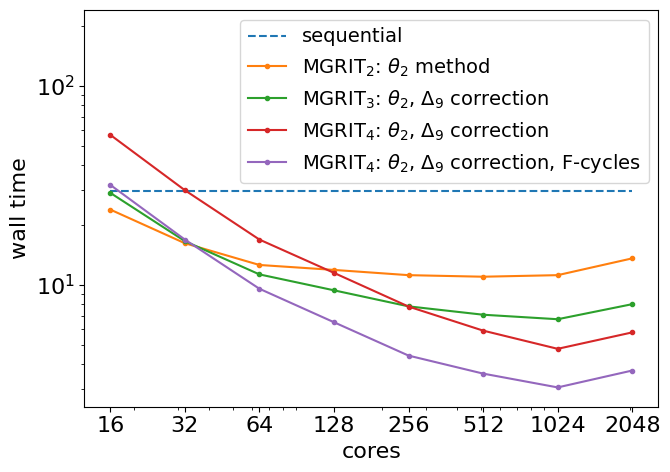

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
ax.loglog(ncores, serial*np.ones(len(ncores)), '--', label="sequential")
ax.loglog(ncores, thetas, '.-', label=r"MGRIT$_2$: $\theta_2$ method")
ax.loglog(ncores, deltas, '.-', label=fr"MGRIT$_3$: $\theta_2$, $\Delta_{{{rank}}}$ correction")
ax.loglog(ncores, delta4, '.-', label=fr"MGRIT$_4$: $\theta_2$, $\Delta_{{{rank}}}$ correction")
ax.loglog(ncores, deltafmg, '.-', label=fr"MGRIT$_4$: $\theta_2$, $\Delta_{{{rank}}}$ correction, F-cycles")
[ax.plot(*pt, 'rx') for pt in bad_pts]
ax.set_xlabel("cores")
ax.set_ylabel("wall time")
ax.legend(loc="upper right", fontsize=14)
plt.xticks(ncores, ncores)
plt.ylim((8e-1*min(deltafmg), 2.4e2))
plt.tight_layout()
plt.savefig("strong_scaling_KS_tf8.png", dpi=300)

In [12]:
serial/thetas

array([1.236, 1.823, 2.344, 2.482, 2.637, 2.685, 2.637, 2.171])

In [13]:
serial/deltas

array([1.018, 1.779, 2.613, 3.142, 3.781, 4.165, 4.388, 3.687])

In [14]:
serial/delta4

array([0.521, 0.988, 1.747, 2.568, 3.791, 5.005, 6.178, 5.109])

In [15]:
serial/deltafmg

array([0.929, 1.747, 3.086, 4.543, 6.681, 8.226, 9.651, 7.939])